In [1]:
# import the necessary packages
import tensorflow as tf
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.callbacks import *
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
# matplotlib.use('Qt5Agg')
import numpy as np
import tempfile
import os
from tqdm import tqdm
# set the matplotlib backend so figures can be saved in the background
import matplotlib
matplotlib.use("Agg")
# import the necessary packages
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import concatenate
import argparse
import cv2
import sys


In [2]:
class MiniGoogLeNet:
    @staticmethod
    def conv_module(x, K, kX, kY, stride, chanDim, padding = "same"):
        # define a CONV => BN => RELU pattern
        x = Conv2D(K, (kX, kY), strides = stride, padding = padding)(x)
        x = BatchNormalization(axis = chanDim)(x)
        x = Activation("relu")(x)

        # return the block
        return x

    @staticmethod
    def inception_module(x, numK1x1, numK3x3, chanDim):
        # define two CONV modules, then concatenate across the channel dimension
        conv_1x1 = MiniGoogLeNet.conv_module(x, numK1x1, 1, 1, (1, 1), chanDim)
        conv_3x3 = MiniGoogLeNet.conv_module(x, numK3x3, 3, 3, (1, 1), chanDim)
        x = concatenate([conv_1x1, conv_3x3], axis = chanDim)

        # return the block
        return x

    @staticmethod
    def downsample_module(x, K, chanDim):
        # define the CONV module and POOL, then concatenate across the channel dimensions
        conv_3x3 = MiniGoogLeNet.conv_module(x, K, 3, 3, (2, 2), chanDim, padding = "valid")
        pool = MaxPooling2D((3, 3), strides = (2, 2))(x)
        x = concatenate([conv_3x3, pool], axis = chanDim)

        # return the block
        return x

    @staticmethod
    def build(width, height, depth, classes):
        # initialize the input shape to be "channel last" and channels dimension itself
        inputShape = (height, width, depth)
        chanDim = -1

        # if we are using "channel first", update the inpute shape and channel dimension
        if K.image_data_format() == "channels_first":
            inputShape = (depth, height, width)
            chanDim = 1

        # define the model input and first CONV module
        inputs = Input(shape = inputShape)
        x = MiniGoogLeNet.conv_module(inputs, 96, 3, 3, (1, 1), chanDim)

        # two Inception modules followed by a downsample module
        x = MiniGoogLeNet.inception_module(x, 32, 32, chanDim)
        x = MiniGoogLeNet.inception_module(x, 32, 48, chanDim)
        x = MiniGoogLeNet.downsample_module(x, 80, chanDim)

        # four Inception module followed by a downsample module
        x = MiniGoogLeNet.inception_module(x, 112, 48, chanDim)
        x = MiniGoogLeNet.inception_module(x, 96, 64, chanDim)
        x = MiniGoogLeNet.inception_module(x, 80, 80, chanDim)
        x = MiniGoogLeNet.inception_module(x, 48, 96, chanDim)
        x = MiniGoogLeNet.downsample_module(x, 96, chanDim)

        # two Inception module followed by global POOL and dropout
        x = MiniGoogLeNet.inception_module(x, 176, 160, chanDim)
        x = MiniGoogLeNet.inception_module(x, 176, 160, chanDim)
        x = AveragePooling2D((7, 7))(x)
        x = Dropout(0.5)(x)

        # softmax classifier
        x = Flatten()(x)
        x = Dense(classes)(x)
        x = Activation("softmax")(x)

        # create the model
        model = Model(inputs, x, name = "googlenet")

        # return the constructed network architecture
        return model

In [3]:
# initialize the list of class label names
CLASSES = ["top", "trouser", "pullover", "dress", "coat",
	"sandal", "shirt", "sneaker", "bag", "ankle boot"]

In [4]:
# load the training and testing data
print("[INFO] loading Fashion MNIST data...")
((trainX, trainY), (testX, testY)) = fashion_mnist.load_data()
# Fashion MNIST images are 28x28 but the network we will be training
# is expecting 32x32 images
trainX = np.array([cv2.resize(x, (32, 32)) for x in trainX])
testX = np.array([cv2.resize(x, (32, 32)) for x in testX])
# scale the pixel intensities to the range [0, 1]
trainX = trainX.astype("float") / 255.0
testX = testX.astype("float") / 255.0
# reshape the data matrices to include a channel dimension (required
# for training)
trainX = trainX.reshape((trainX.shape[0], 32, 32, 1))
testX = testX.reshape((testX.shape[0], 32, 32, 1))
# convert the labels from integers to vectors
lb = LabelBinarizer()
trainY = lb.fit_transform(trainY)
testY = lb.transform(testY)
# construct the image generator for data augmentation
aug = ImageDataGenerator(width_shift_range=0.1,
	height_shift_range=0.1, horizontal_flip=True,
	fill_mode="nearest")

[INFO] loading Fashion MNIST data...
4422102/4422102 [==============================] - 0s 0us/step


In [5]:
def fetch_batch(X, y, batch_size, batch):
    start = batch*batch_size
    
    X_batch = X[start:start+batch_size, :, :]
    y_batch = y[start:start+batch_size, :]
    
    return X_batch, y_batch

In [6]:
MAX_LR = 1e-1
batch_size = 32
loss_history = []
acc_history = []
n_epochs = 50
model = MiniGoogLeNet.build(width=32, height=32, depth=1, classes=10)
loss_fn = tf.keras.losses.CategoricalCrossentropy()
acc_metric = tf.keras.metrics.CategoricalAccuracy()
opt = SGD(learning_rate=MAX_LR, momentum=0.9)
tf.compat.v1.enable_eager_execution()

In [7]:
batches = [32,32,32,64,64,128,256,512,512,1024,2048,2048,4096,8192,8192,16384,16384]
tot_steps = len(batches)

In [8]:
gradients = []
for epoch in range(n_epochs):
    batch_size = 32
    gradients = []
    counter = 0
    loss = []
    totloss = 0
    iter = 0
    train_vars = model.trainable_variables
    accum_gradient = [tf.zeros_like(this_var) for this_var in train_vars]
    for batch in tqdm(range(len(trainX) //batch_size), desc ="Epoch: {}/{} ".format(epoch + 1, n_epochs)):
        X_batch, y_batch = fetch_batch(trainX, trainY, batch_size, batch)
        with tf.GradientTape() as tape:
            y_pred = model(X_batch, training = True)
            loss = loss_fn(y_batch, y_pred)
        totloss += loss
        gradients = tape.gradient(loss, train_vars)
        accum_gradient = [(acum_grad+grad) for acum_grad, grad in zip(accum_gradient, gradients)]
        counter = counter + 32
        acc_metric.update_state(y_batch, y_pred)
        if(counter == batches[iter]):
          accum_gradient = [this_grad/batches[iter] for this_grad in accum_gradient]
          opt.apply_gradients(zip(accum_gradient,train_vars))
          gradients = []
          counter = 0
          iter = iter + 1
          accum_gradient = [tf.zeros_like(this_var) for this_var in train_vars]
    train_acc = acc_metric.result()
    print(f"Accuracy over epoch {'{:.4f}'.format(train_acc*100)} & Loss over epoch {'{:.4f}'.format(totloss / (len(trainX) //batch_size))} ")
    loss_history.append(totloss)
    acc_history.append(train_acc)
    acc_metric.reset_state()

Epoch: 1/50 : 100%|██████████| 1875/1875 [02:13<00:00, 14.05it/s]


Accuracy over epoch 35.8017 & Loss over epoch 1.8210 


Epoch: 2/50 : 100%|██████████| 1875/1875 [01:51<00:00, 16.74it/s]


Accuracy over epoch 55.8717 & Loss over epoch 1.2933 


Epoch: 3/50 : 100%|██████████| 1875/1875 [01:51<00:00, 16.82it/s]


Accuracy over epoch 64.5700 & Loss over epoch 1.0505 


Epoch: 4/50 : 100%|██████████| 1875/1875 [01:52<00:00, 16.73it/s]


Accuracy over epoch 68.6983 & Loss over epoch 0.9175 


Epoch: 5/50 : 100%|██████████| 1875/1875 [01:51<00:00, 16.85it/s]


Accuracy over epoch 70.9300 & Loss over epoch 0.8382 


Epoch: 6/50 : 100%|██████████| 1875/1875 [01:51<00:00, 16.88it/s]


Accuracy over epoch 72.6217 & Loss over epoch 0.7830 


Epoch: 7/50 : 100%|██████████| 1875/1875 [01:50<00:00, 16.98it/s]


Accuracy over epoch 73.7567 & Loss over epoch 0.7420 


Epoch: 8/50 : 100%|██████████| 1875/1875 [01:50<00:00, 16.99it/s]


Accuracy over epoch 74.7617 & Loss over epoch 0.7108 


Epoch: 9/50 : 100%|██████████| 1875/1875 [01:49<00:00, 17.11it/s]


Accuracy over epoch 75.4400 & Loss over epoch 0.6886 


Epoch: 10/50 : 100%|██████████| 1875/1875 [01:49<00:00, 17.18it/s]


Accuracy over epoch 76.5350 & Loss over epoch 0.6565 


Epoch: 11/50 : 100%|██████████| 1875/1875 [01:48<00:00, 17.23it/s]


Accuracy over epoch 77.1567 & Loss over epoch 0.6402 


Epoch: 12/50 : 100%|██████████| 1875/1875 [01:48<00:00, 17.31it/s]


Accuracy over epoch 77.8500 & Loss over epoch 0.6169 


Epoch: 13/50 : 100%|██████████| 1875/1875 [01:48<00:00, 17.28it/s]


Accuracy over epoch 78.6583 & Loss over epoch 0.5945 


Epoch: 14/50 : 100%|██████████| 1875/1875 [01:48<00:00, 17.24it/s]


Accuracy over epoch 79.2383 & Loss over epoch 0.5815 


Epoch: 15/50 : 100%|██████████| 1875/1875 [01:48<00:00, 17.31it/s]


Accuracy over epoch 79.6683 & Loss over epoch 0.5695 


Epoch: 16/50 : 100%|██████████| 1875/1875 [01:48<00:00, 17.22it/s]


Accuracy over epoch 80.2250 & Loss over epoch 0.5570 


Epoch: 17/50 : 100%|██████████| 1875/1875 [01:48<00:00, 17.33it/s]


Accuracy over epoch 80.9533 & Loss over epoch 0.5428 


Epoch: 18/50 : 100%|██████████| 1875/1875 [01:48<00:00, 17.33it/s]


Accuracy over epoch 81.5400 & Loss over epoch 0.5267 


Epoch: 19/50 : 100%|██████████| 1875/1875 [01:48<00:00, 17.23it/s]


Accuracy over epoch 81.7217 & Loss over epoch 0.5188 


Epoch: 20/50 : 100%|██████████| 1875/1875 [01:48<00:00, 17.30it/s]


Accuracy over epoch 81.8383 & Loss over epoch 0.5138 


Epoch: 21/50 : 100%|██████████| 1875/1875 [01:48<00:00, 17.31it/s]


Accuracy over epoch 82.4567 & Loss over epoch 0.4991 


Epoch: 22/50 : 100%|██████████| 1875/1875 [01:48<00:00, 17.25it/s]


Accuracy over epoch 82.6167 & Loss over epoch 0.4929 


Epoch: 23/50 : 100%|██████████| 1875/1875 [01:48<00:00, 17.30it/s]


Accuracy over epoch 83.1650 & Loss over epoch 0.4773 


Epoch: 24/50 : 100%|██████████| 1875/1875 [01:48<00:00, 17.34it/s]


Accuracy over epoch 83.4050 & Loss over epoch 0.4748 


Epoch: 25/50 : 100%|██████████| 1875/1875 [01:48<00:00, 17.30it/s]


Accuracy over epoch 83.5967 & Loss over epoch 0.4669 


Epoch: 26/50 : 100%|██████████| 1875/1875 [01:48<00:00, 17.34it/s]


Accuracy over epoch 84.1950 & Loss over epoch 0.4530 


Epoch: 27/50 : 100%|██████████| 1875/1875 [01:48<00:00, 17.34it/s]


Accuracy over epoch 84.2817 & Loss over epoch 0.4471 


Epoch: 28/50 : 100%|██████████| 1875/1875 [01:48<00:00, 17.33it/s]


Accuracy over epoch 84.4500 & Loss over epoch 0.4448 


Epoch: 29/50 : 100%|██████████| 1875/1875 [01:48<00:00, 17.32it/s]


Accuracy over epoch 84.8850 & Loss over epoch 0.4336 


Epoch: 30/50 : 100%|██████████| 1875/1875 [01:48<00:00, 17.21it/s]


Accuracy over epoch 84.8433 & Loss over epoch 0.4288 


Epoch: 31/50 : 100%|██████████| 1875/1875 [01:48<00:00, 17.23it/s]


Accuracy over epoch 85.2800 & Loss over epoch 0.4236 


Epoch: 32/50 : 100%|██████████| 1875/1875 [01:48<00:00, 17.23it/s]


Accuracy over epoch 85.3617 & Loss over epoch 0.4184 


Epoch: 33/50 : 100%|██████████| 1875/1875 [01:48<00:00, 17.20it/s]


Accuracy over epoch 85.4633 & Loss over epoch 0.4141 


Epoch: 34/50 : 100%|██████████| 1875/1875 [01:49<00:00, 17.12it/s]


Accuracy over epoch 85.5250 & Loss over epoch 0.4129 


Epoch: 35/50 : 100%|██████████| 1875/1875 [01:48<00:00, 17.21it/s]


Accuracy over epoch 85.6450 & Loss over epoch 0.4105 


Epoch: 36/50 : 100%|██████████| 1875/1875 [01:48<00:00, 17.20it/s]


Accuracy over epoch 85.9750 & Loss over epoch 0.4026 


Epoch: 37/50 : 100%|██████████| 1875/1875 [01:48<00:00, 17.24it/s]


Accuracy over epoch 85.9600 & Loss over epoch 0.3989 


Epoch: 38/50 : 100%|██████████| 1875/1875 [01:48<00:00, 17.29it/s]


Accuracy over epoch 86.0433 & Loss over epoch 0.4006 


Epoch: 39/50 : 100%|██████████| 1875/1875 [01:49<00:00, 17.12it/s]


Accuracy over epoch 86.1800 & Loss over epoch 0.3981 


Epoch: 40/50 : 100%|██████████| 1875/1875 [01:49<00:00, 17.06it/s]


Accuracy over epoch 86.4317 & Loss over epoch 0.3860 


Epoch: 41/50 : 100%|██████████| 1875/1875 [01:49<00:00, 17.12it/s]


Accuracy over epoch 86.7683 & Loss over epoch 0.3800 


Epoch: 42/50 : 100%|██████████| 1875/1875 [01:49<00:00, 17.19it/s]


Accuracy over epoch 86.7650 & Loss over epoch 0.3795 


Epoch: 43/50 : 100%|██████████| 1875/1875 [01:48<00:00, 17.30it/s]


Accuracy over epoch 87.0317 & Loss over epoch 0.3724 


Epoch: 44/50 : 100%|██████████| 1875/1875 [01:48<00:00, 17.36it/s]


Accuracy over epoch 87.1783 & Loss over epoch 0.3695 


Epoch: 45/50 : 100%|██████████| 1875/1875 [01:48<00:00, 17.32it/s]


Accuracy over epoch 87.3967 & Loss over epoch 0.3635 


Epoch: 46/50 : 100%|██████████| 1875/1875 [01:48<00:00, 17.33it/s]


Accuracy over epoch 87.3767 & Loss over epoch 0.3621 


Epoch: 47/50 : 100%|██████████| 1875/1875 [01:48<00:00, 17.31it/s]


Accuracy over epoch 87.4783 & Loss over epoch 0.3590 


Epoch: 48/50 : 100%|██████████| 1875/1875 [01:48<00:00, 17.35it/s]


Accuracy over epoch 87.8383 & Loss over epoch 0.3518 


Epoch: 49/50 : 100%|██████████| 1875/1875 [01:47<00:00, 17.37it/s]


Accuracy over epoch 87.7467 & Loss over epoch 0.3546 


Epoch: 50/50 : 100%|██████████| 1875/1875 [01:47<00:00, 17.39it/s]

Accuracy over epoch 87.8967 & Loss over epoch 0.3493 


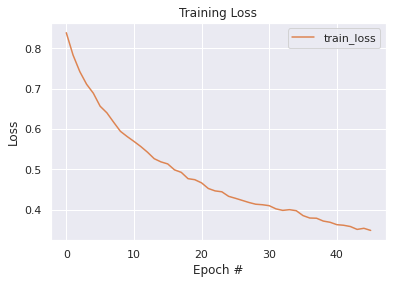

In [13]:
N = np.arange(0, n_epochs-4)
loss_history = [loss_history[idx].numpy()/(len(trainX) //batch_size) for idx, i in enumerate(loss_history)][4:]
%matplotlib inline
plt.close('all')
sns.lineplot(x=N, y=loss_history, color=sns.color_palette()[1], label="train_loss");
plt.title("Training Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.show()

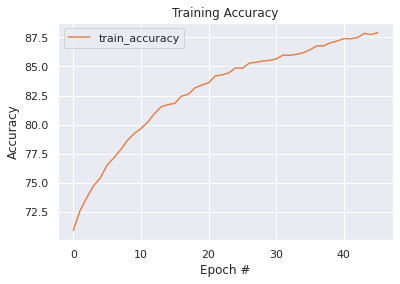

In [14]:
acc_history = [acc_history[idx].numpy()*100 for idx, i in enumerate(acc_history)][4:]
%matplotlib inline
plt.close('all')
sns.lineplot(x=N, y=acc_history, color=sns.color_palette()[1], label="train_accuracy");
plt.title("Training Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.show()

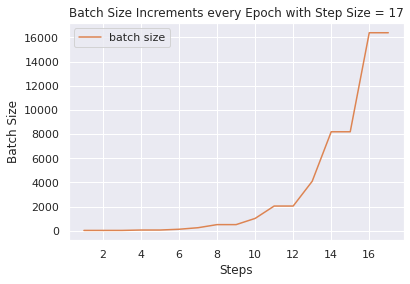

In [15]:
st = np.arange(1, len(batches) + 1)
%matplotlib inline
plt.close('all')
sns.lineplot(x=st, y=batches, color=sns.color_palette()[1], label="batch size");
plt.title("Batch Size Increments every Epoch with Step Size = 17")
plt.xlabel("Steps")
plt.ylabel("Batch Size")
plt.show()

Inference:

The generalization of this particular model where the batch size increments from 32 until 16384 by a factor of 2 starting every epoch is much better than the other model.